# Computing Wind-Adjusted Fire Risk

In this tutorial, you'll learn how to calculate wind-adjusted fire risk for a specific region using the Open Climate Risk(OCR) framework. This hands-on guide will walk you through the complete workflow, from configuring your environment to visualizing the results.

## What you'll learn

By the end of this tutorial, you'll understand how to:

- Configure the OCR framework for local computation
- Work with spatial chunks to process regional data
- Calculate wind-adjusted fire risk for a specific area
- Visualize and compare fire risk across different time periods

## Background

Wind-adjusted fire risk accounts for how prevailing wind patterns affect the spread and intensity of wildfires. The OCR framework combines historical fire risk data from the USFS (U.S. Forest Service) with wind data from the CONUS404 dataset to provide a more accurate picture of fire risk across different time periods.

Let's get started!

## Step 1: Import required modules

First, we'll import the necessary components from the OCR package. The `OCRConfig` class manages all configuration settings, while `calculate_wind_adjusted_risk` is the core function that performs our fire risk calculations.

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from ocr.config import OCRConfig
from ocr.pipeline.process_region import sample_risk_to_buildings
from ocr.risks.fire import calculate_wind_adjusted_risk

## Step 2: Configure your environment

Next, we'll set up our OCR configuration. For this tutorial, we're using:
- A temporary local storage location (`/tmp/ocr-testing`)
- Debug mode enabled to get more detailed output

The configuration object handles all the settings needed for data processing, including chunking strategies, storage paths, and Icechunk repository settings.

In [2]:
config = OCRConfig(storage_root='/tmp/ocr-testing', debug=True)
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=True), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=True), pyramid=PyramidConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', output_prefix='output/fire-risk/pyramid/qa/pyramid.zarr', debug=True), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=True)

## Step 3: Initialize the Icechunk repository

The Icechunk repository is a versioned data store that OCR uses to manage intermediate and final datasets. Initializing it creates the necessary directory structure and metadata for storing our computed results.

In [3]:
config.icechunk.init_repo()

  2025-12-18T15:34:35.805653Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



[15:34:35] Initialized/Opened icechunk repository                                                    ]8;id=787021;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=249424;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1023\1023]8;;\

           Opened icechunk repository at /tmp/ocr-testing/output/fire-risk/tensor/qa/ocr.icechunk    ]8;id=428721;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=72027;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1040\1040]8;;\
           with branch main in readonly mode.                                                                      

           No template found in icechunk store. Creating a new template dataset.                     ]8;id=837435;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=945389;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1027\1027]8;;\

           Opened icechunk repository at /tmp/ocr-testing/output/fire-risk/tensor/qa/ocr.icechunk    ]8;id=205684;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=767687;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1040\1040]8;;\
           with branch main in writable mode.                                                                      

[15:34:36] Created icechunk template                                                                 ]8;id=404918;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=754764;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1125\1125]8;;\

## Step 4: Visualize the spatial chunking strategy

To efficiently process large climate datasets, OCR divides the geographic domain into smaller spatial chunks. This visualization shows how the study area is divided into regions that can be processed independently.

Each chunk is identified by a unique `region_id` in the format `y{row}_x{column}`.

/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


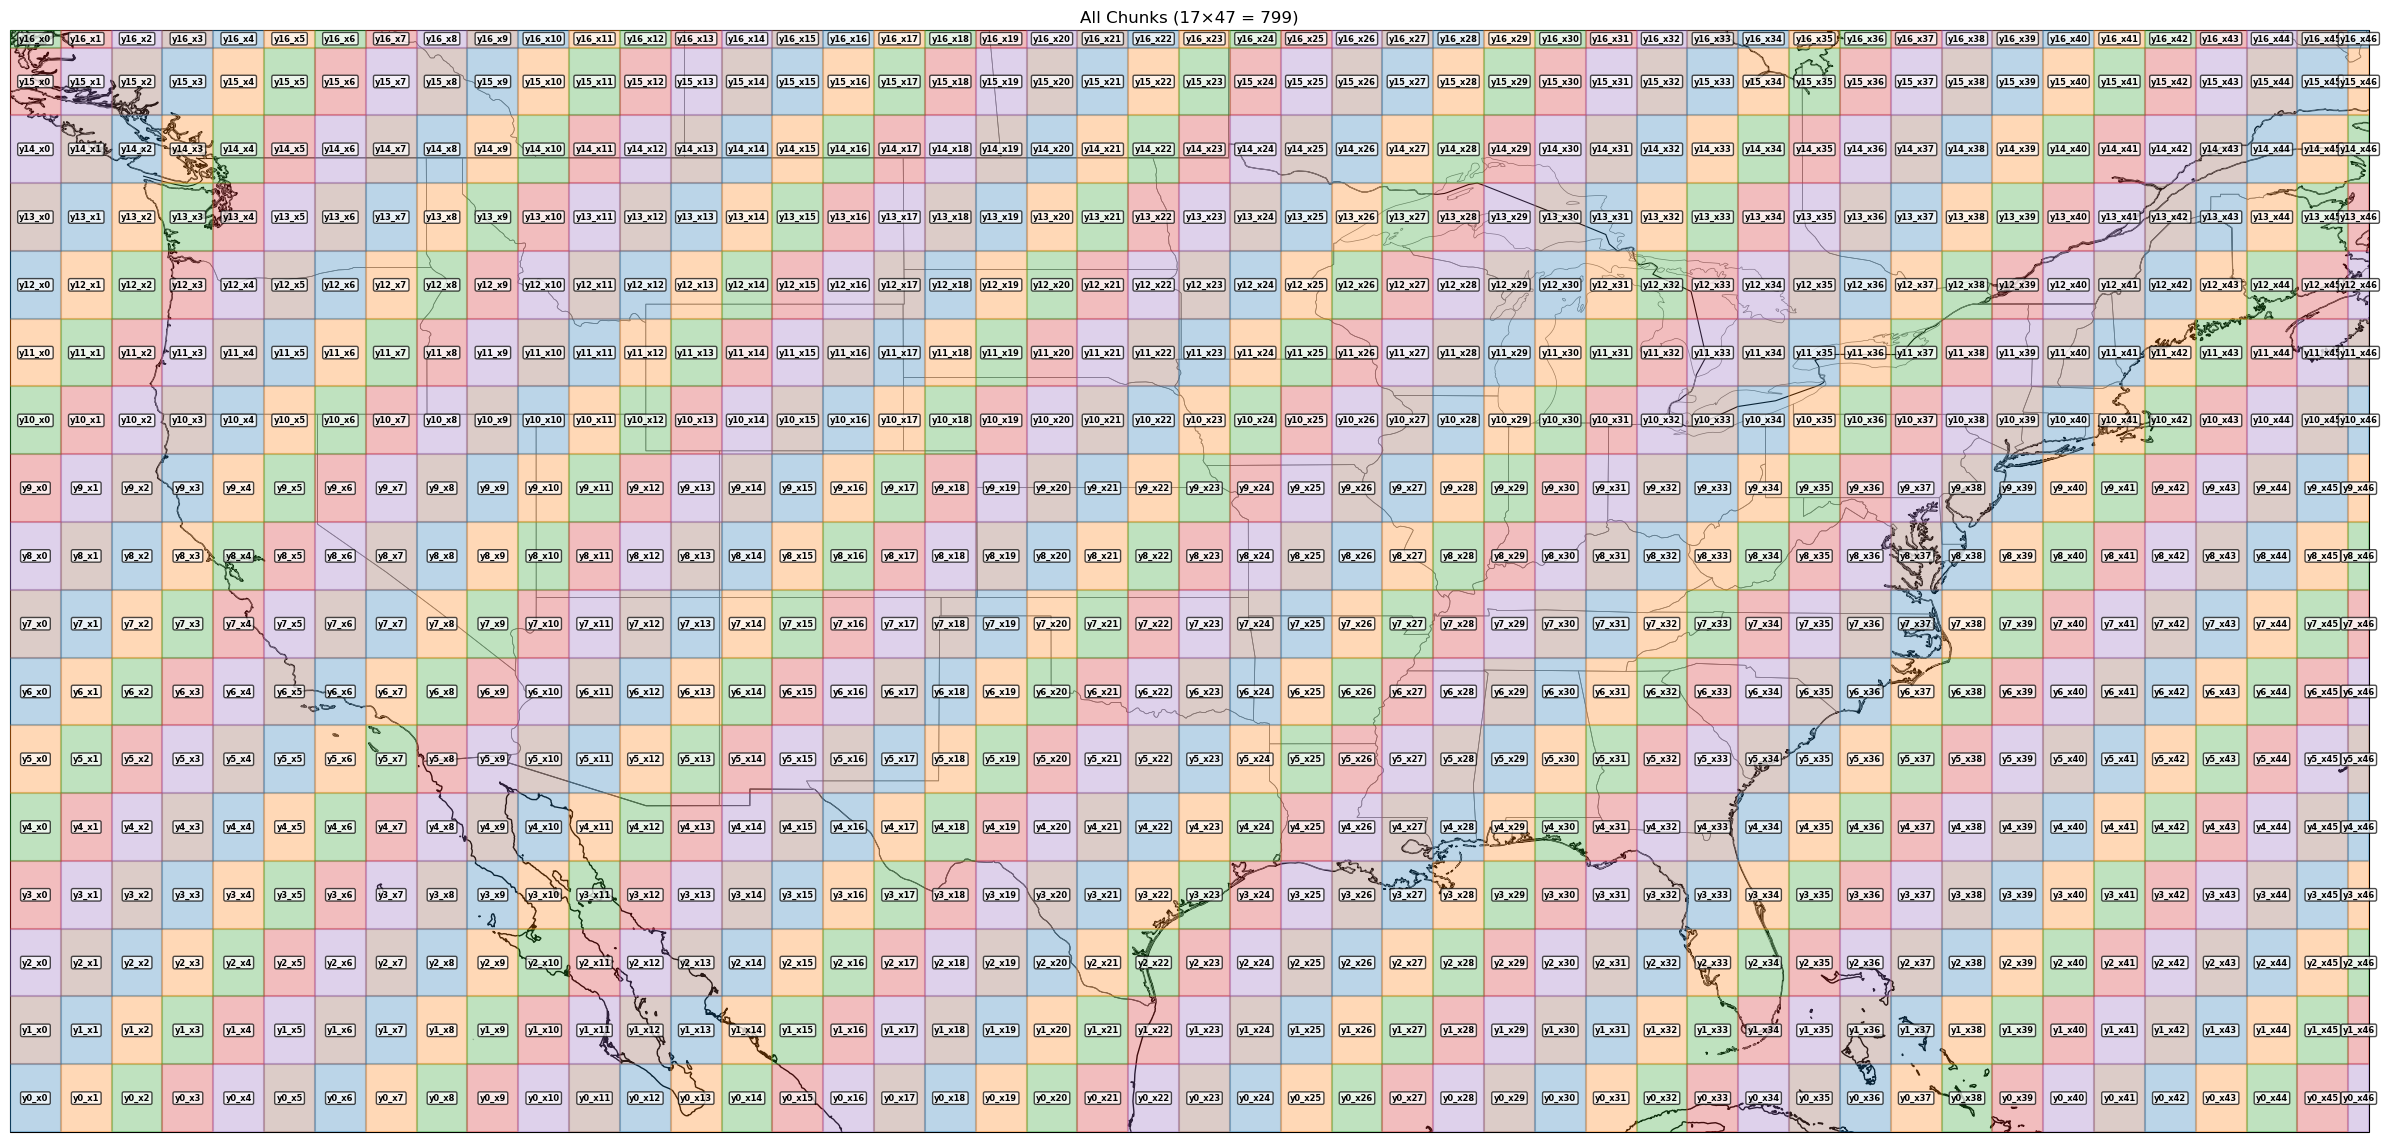

In [4]:
config.chunking.plot_all_chunks()

## Step 5: Select a region to analyze

Now we'll select a specific region to compute fire risk for. In this example, we're using region `y6_x7`, but you can choose any region from the chunking visualization above.

The `region_id_to_latlon_slices` method converts the region identifier into latitude and longitude slice objects that define the exact geographic bounds of our area of interest.

In [5]:
region_id = 'y6_x7'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice

(slice(np.float64(33.515893851345204), np.float64(35.363857121965516), None),
 slice(np.float64(-118.68574904867506), np.float64(-117.29977659570983), None))

## Step 6: Calculate wind-adjusted fire risk

This is where the magic happens! The `calculate_wind_adjusted_risk` function:

1. Loads the baseline USFS fire risk data for your region
2. Retrieves wind data from the CONUS404 dataset
3. Applies wind adjustment calculations to estimate how wind patterns affect fire spread
4. Returns a dataset with fire risk estimates for different time periods

The `%%time` magic command helps us see how long the calculation takes. Depending on the region size and your system, this may take a few minutes.

In [6]:
%%time
ds = calculate_wind_adjusted_risk(y_slice=y_slice, x_slice=x_slice)
ds

CPU times: user 2min 7s, sys: 7.16 s, total: 2min 14s
Wall time: 2min 5s


<xarray.Dataset> Size: 864MB
Dimensions:                     (longitude: 4500, latitude: 6000)
Coordinates:
  * longitude                   (longitude) float64 36kB -118.7 ... -117.3
  * latitude                    (latitude) float64 48kB 33.52 33.52 ... 35.36
Data variables:
    USFS_RPS                    (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2011              (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2047              (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_2011       (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_2047       (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    conditional_risk_usfs       (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_usfs_2011  (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    burn_probability_usfs_2047  (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

## Step 7: Visualize the gridded fire risk results

Now let's create a comprehensive visualization comparing all three fire risk metrics side-by-side. This allows us to easily compare:

- **Historical wind-adjusted risk (2011)**: Fire risk with wind patterns from the historical period
- **Future wind-adjusted risk (2047)**: Projected fire risk with modeled future wind patterns
- **Baseline USFS risk**: Original fire risk without directional wind effects

The side-by-side comparison makes it easy to identify how wind adjustments modify the baseline risk and how risk patterns may change in the future.

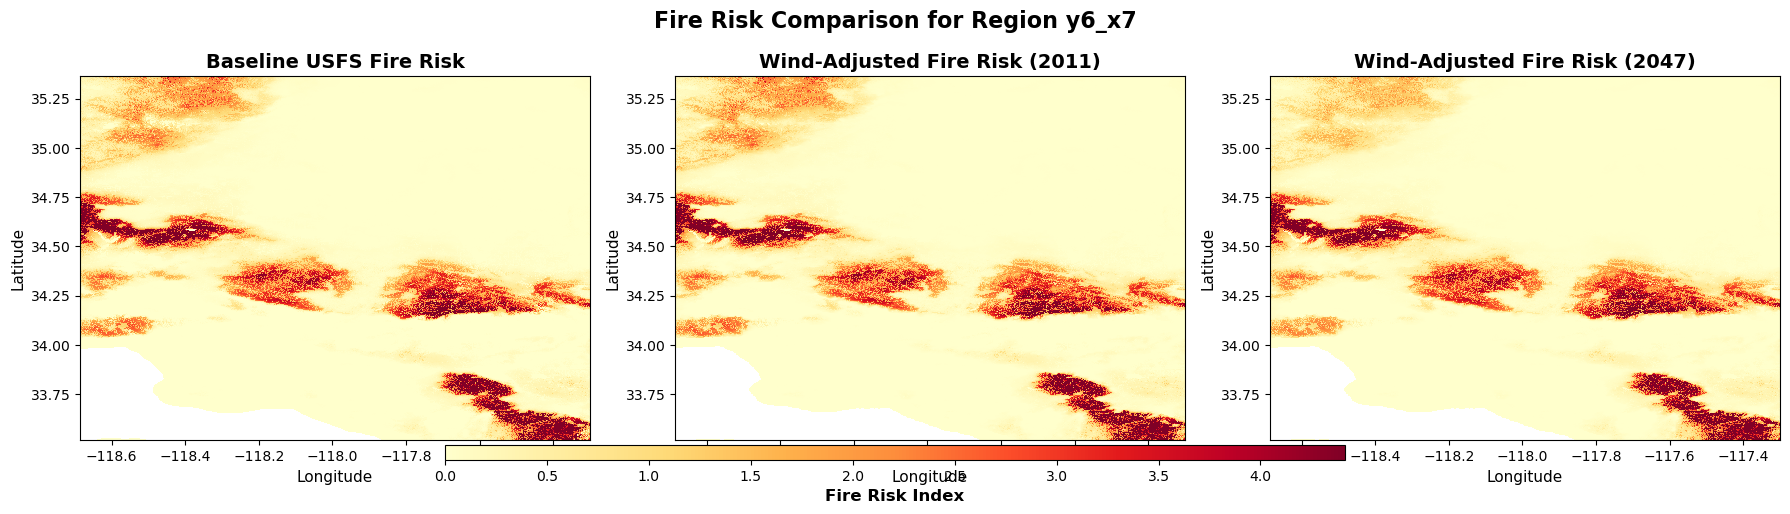

In [7]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define a consistent colormap and scaling for all plots
cmap = 'YlOrRd'  # Yellow-Orange-Red colormap (fire-appropriate)

# Plot 3: Baseline USFS fire risk
im1 = ds.USFS_RPS.plot(ax=axes[0], cmap=cmap, robust=True, add_colorbar=False)
axes[0].set_title('Baseline USFS Fire Risk', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude', fontsize=11)
axes[0].set_ylabel('Latitude', fontsize=11)

# Plot 1: Historical wind-adjusted fire risk (2011)
im1 = ds.wind_risk_2011.plot(ax=axes[1], cmap=cmap, robust=True, add_colorbar=False)
axes[1].set_title('Wind-Adjusted Fire Risk (2011)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude', fontsize=11)
axes[1].set_ylabel('Latitude', fontsize=11)

# Plot 2: Future wind-adjusted fire risk (2047)
im2 = ds.wind_risk_2047.plot(ax=axes[2], cmap=cmap, robust=True, add_colorbar=False)
axes[2].set_title('Wind-Adjusted Fire Risk (2047)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Longitude', fontsize=11)
axes[2].set_ylabel('Latitude', fontsize=11)


# Add a shared colorbar at the bottom
fig.subplots_adjust(bottom=0.15, wspace=0.3)
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fire Risk Index', fontsize=12, fontweight='bold')

# Add overall title
fig.suptitle(f'Fire Risk Comparison for Region {region_id}', fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

### Interpreting the results

Looking at the three panels:

- **Left panel (2011)**: Shows how historical wind patterns affected fire risk. Notice how the wind adjustment creates directional patterns compared to the baseline.

- **Middle panel (2047)**: Reveals projected future fire risk with changing wind patterns. Compare this with the 2011 panel to identify areas where risk may increase or decrease.

- **Right panel (Baseline)**: The USFS Relative Fire Potential Score provides the foundation for our wind adjustments. This represents fire risk based on fuel, topography, and climate factors without directional wind effects.

The consistent color scale across all three plots makes it easy to compare risk levels directly.

## Step 8: Sample fire risk at building locations

Now that we have our wind-adjusted fire risk data, let's make it more practical by sampling the risk values at actual building locations. The `sample_risk_to_buildings` function:

1. Loads building footprint data for the region (from Overture Maps or similar sources)
2. Extracts the fire risk values at each building location
3. Returns a GeoDataFrame with building geometries and their associated risk values

This transforms our gridded risk data into actionable information for specific structures, which is crucial for risk assessment and planning.

In [8]:
%%time
buildings_gdf = sample_risk_to_buildings(ds=ds)
buildings_gdf.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 1min 42s, sys: 8.75 s, total: 1min 51s
Wall time: 1min 37s


,USFS_RPS,wind_risk_2011,wind_risk_2047,burn_probability_2011,burn_probability_2047,conditional_risk_usfs,burn_probability_usfs_2011,burn_probability_usfs_2047,GEOID,state,county,geometry
0,0.000000,0.000000,0.000000,0.010478,0.010918,0.000000,0.0,0.0,060371220001011,CA,Los Angeles County,"POLYGON ((-118.42295 34.21289, -118.42291 34.2..."
1,0.000000,0.000000,0.000000,0.000576,0.000997,0.000000,0.0,0.0,060371190041004,CA,Los Angeles County,"POLYGON ((-118.42293 34.24169, -118.42295 34.2..."
2,0.000000,0.000000,0.000000,0.002886,0.008652,0.000000,0.0,0.0,060372753114003,CA,Los Angeles County,"POLYGON ((-118.42293 33.98474, -118.42295 33.9..."
3,0.000000,0.000000,0.000000,0.006529,0.012843,0.000000,0.0,0.0,060371198022000,CA,Los Angeles County,"POLYGON ((-118.42294 34.23624, -118.42291 34.2..."
4,0.003214,0.134529,0.250614,0.394772,0.735419,34.077751,0.0,0.0,060371061121008,CA,Los Angeles County,"POLYGON ((-118.42292 34.31885, -118.42293 34.3..."


### Visualizing buildings and their fire risk

Let's create a map showing building locations colored by their fire risk levels. This visualization helps us:

- Identify high-risk buildings that may need prioritized protection
- Understand the spatial distribution of risk at the structure level
- See how risk varies across different neighborhoods or areas

We'll create side-by-side maps showing the 2011 and 2047 wind-adjusted risk for buildings.

### Exploring the building-level risk data

The GeoDataFrame contains individual buildings with their associated fire risk values. Let's examine the first few entries to see what information is available for each building.

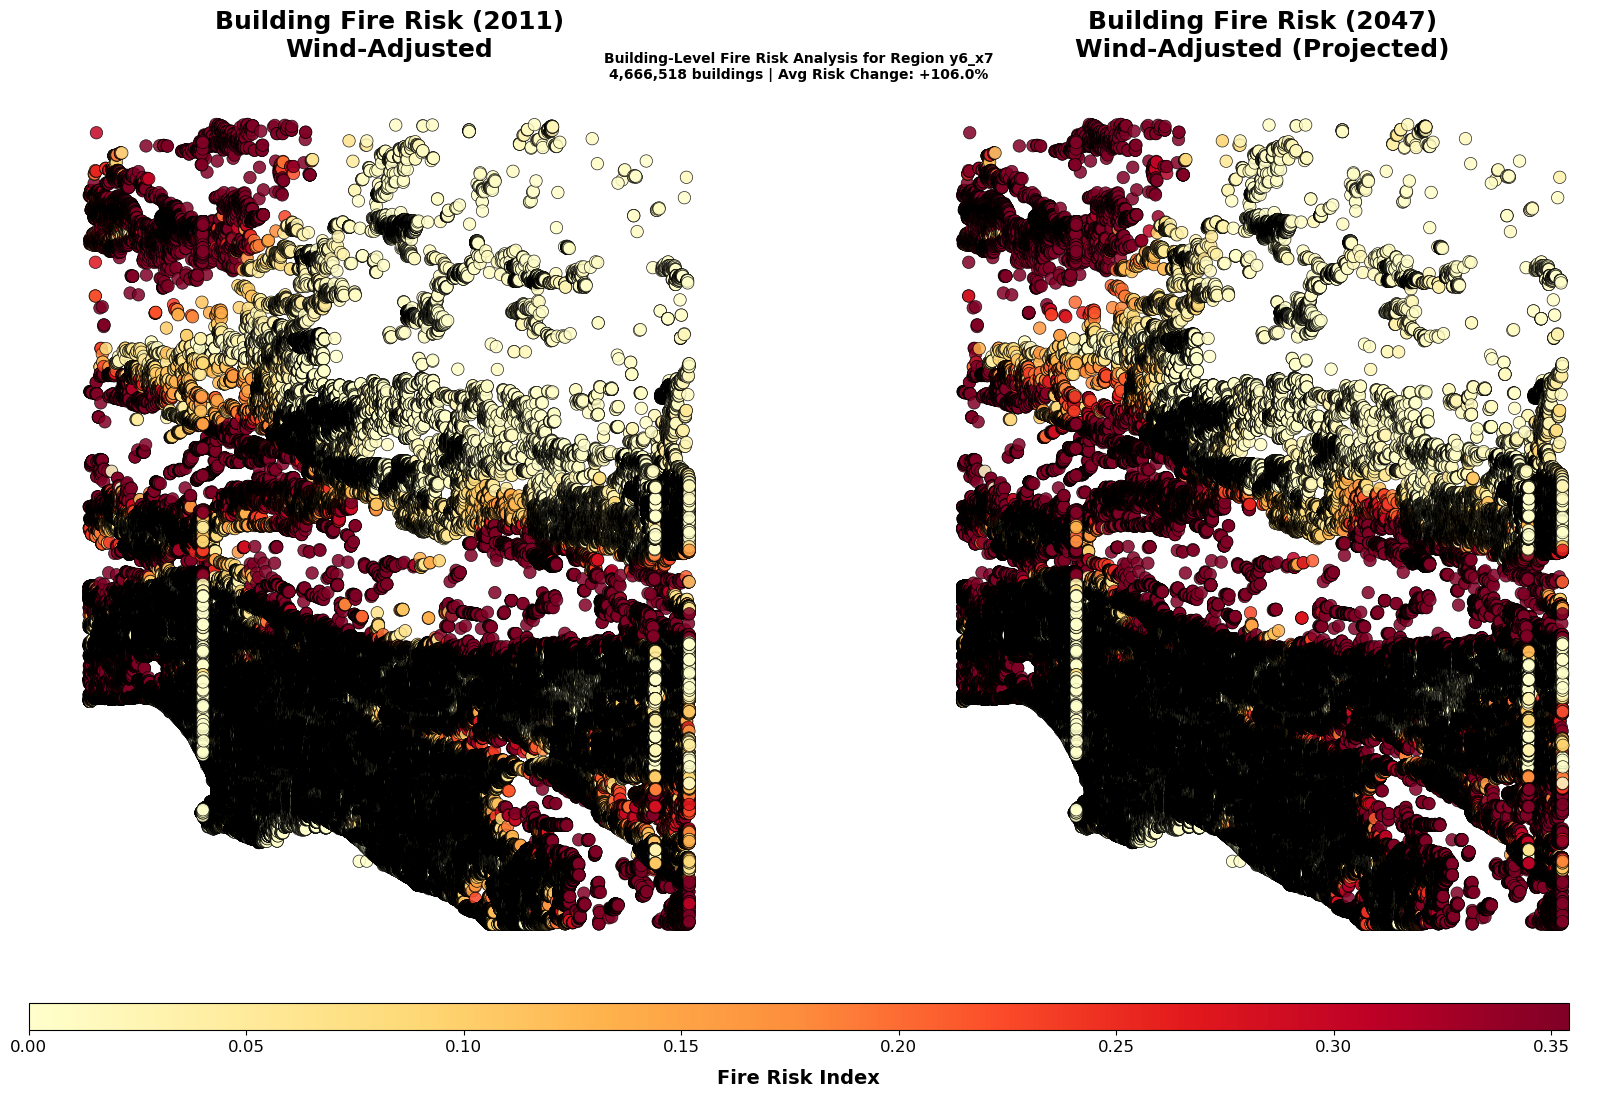


Building Fire Risk Summary
Total Buildings Analyzed: 4,666,518

2011 Wind-Adjusted Risk:
  Mean:   0.037
  Median: 0.000
  Min:    0.000
  Max:    7.562

2047 Wind-Adjusted Risk:
  Mean:   0.076
  Median: 0.000
  Min:    0.000
  Max:    15.156

Projected Change: +106.0%


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(22, 11))

# Calculate SHARED vmin/vmax across both time periods for consistent comparison
vmin_shared = min(
    buildings_gdf['wind_risk_2011'].quantile(0.05), buildings_gdf['wind_risk_2047'].quantile(0.05)
)
vmax_shared = max(
    buildings_gdf['wind_risk_2011'].quantile(0.95), buildings_gdf['wind_risk_2047'].quantile(0.95)
)

# Create explicit colormap and normalization
cmap = plt.cm.YlOrRd
norm = mcolors.Normalize(vmin=vmin_shared, vmax=vmax_shared)

# Get centroids of building polygons
centroids = buildings_gdf.geometry.centroid

# Plot 1: 2011 Wind-Adjusted Risk - SCATTER PLOT OF CENTROIDS
axes[0].scatter(
    centroids.x,
    centroids.y,
    c=buildings_gdf['wind_risk_2011'],
    cmap=cmap,
    norm=norm,
    s=80,  # Point size
    alpha=0.85,
    edgecolors='black',
    linewidth=0.5,
)
axes[0].set_title(
    'Building Fire Risk (2011)\nWind-Adjusted', fontsize=18, fontweight='bold', pad=20
)
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot 2: 2047 Wind-Adjusted Risk - SCATTER PLOT OF CENTROIDS
axes[1].scatter(
    centroids.x,
    centroids.y,
    c=buildings_gdf['wind_risk_2047'],
    cmap=cmap,
    norm=norm,
    s=80,  # Point size
    alpha=0.85,
    edgecolors='black',
    linewidth=0.5,
)
axes[1].set_title(
    'Building Fire Risk (2047)\nWind-Adjusted (Projected)', fontsize=18, fontweight='bold', pad=20
)
axes[1].set_aspect('equal')
axes[1].axis('off')

# Add overall title and statistics
n_buildings = len(buildings_gdf)
mean_risk_2011 = buildings_gdf['wind_risk_2011'].mean()
mean_risk_2047 = buildings_gdf['wind_risk_2047'].mean()
risk_change = ((mean_risk_2047 - mean_risk_2011) / mean_risk_2011) * 100

fig.suptitle(
    f'Building-Level Fire Risk Analysis for Region {region_id}\n'
    f'{n_buildings:,} buildings | '
    f'Avg Risk Change: {risk_change:+.1f}%',
    fontsize=10,
    fontweight='bold',
    y=0.95,
)

# Add a SINGLE shared colorbar at the bottom
fig.subplots_adjust(bottom=0.12, wspace=0.05, top=0.92)
cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.025])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fire Risk Index', fontsize=14, fontweight='bold', labelpad=10)
cbar.ax.tick_params(labelsize=12)

plt.show()

# Print summary statistics
print(f'\n{"=" * 60}')
print('Building Fire Risk Summary')
print(f'{"=" * 60}')
print(f'Total Buildings Analyzed: {n_buildings:,}')
print('\n2011 Wind-Adjusted Risk:')
print(f'  Mean:   {mean_risk_2011:.3f}')
print(f'  Median: {buildings_gdf["wind_risk_2011"].median():.3f}')
print(f'  Min:    {buildings_gdf["wind_risk_2011"].min():.3f}')
print(f'  Max:    {buildings_gdf["wind_risk_2011"].max():.3f}')
print('\n2047 Wind-Adjusted Risk:')
print(f'  Mean:   {mean_risk_2047:.3f}')
print(f'  Median: {buildings_gdf["wind_risk_2047"].median():.3f}')
print(f'  Min:    {buildings_gdf["wind_risk_2047"].min():.3f}')
print(f'  Max:    {buildings_gdf["wind_risk_2047"].max():.3f}')
print(f'\nProjected Change: {risk_change:+.1f}%')
print(f'{"=" * 60}')

### Understanding the building-level risk patterns

The maps above show individual buildings colored by their fire risk values:

- **Darker red points** indicate buildings with higher fire risk
- **Lighter yellow points** show buildings with lower fire risk
- The **basemap** provides geographic context (roads, terrain, etc.)

Key observations to look for:

1. **Spatial clustering**: Do high-risk buildings cluster in certain areas?
2. **Temporal changes**: How does the risk distribution shift between 2011 and 2047?
3. **Risk magnitude**: What percentage of buildings fall into high-risk categories?

The summary statistics below the plot provide quantitative measures of the risk distribution and how it's projected to change over time.

## Step 9: Store results in the Icechunk repository

Finally, let's save our computed wind-adjusted fire risk data to the Icechunk repository. This allows us to:

- Version our results for reproducibility
- Efficiently store and retrieve processed data
- Build up a library of regional analyses over time

The `insert_region_uncooperative` method writes the dataset to the repository with the appropriate region identifier.

In [10]:
%%time
config.icechunk.insert_region_uncooperative(ds.chunk(config.chunking.chunks), region_id=region_id)

[15:40:45] Inserting region: y6_x7 into Icechunk store:                                              ]8;id=280547;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=685585;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1178\1178]8;;\

           Opened icechunk repository at /tmp/ocr-testing/output/fire-risk/tensor/qa/ocr.icechunk    ]8;id=78425;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=278277;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1040\1040]8;;\
           with branch main in writable mode.                                                                      

[15:40:47] Wrote dataset: <xarray.Dataset> Size: 864MB                                               ]8;id=494589;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py\config.py]8;;\:]8;id=891930;file:///opt/coiled/env/lib/python3.13/site-packages/ocr/config.py#1194\1194]8;;\
           Dimensions:                     (longitude: 4500, latitude: 6000)                                       
           Coordinates:                                                                                            
             * longitude                   (longitude) float64 36kB -118.7 ... -117.3                              
             * latitude                    (latitude) float64 48kB 33.52 33.52 ... 35.36                           
           Data variables:                                                                                         
               USFS_RPS                    (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               wind_risk_2011              (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               wind_risk_2047              (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               burn_probability_2011       (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               burn_probability_2047       (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               conditional_risk_usfs       (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               burn_probability_usfs_2011  (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray>                                                     
               burn_probability_usfs_2047  (latitude, longitude) float32 108MB                                     
           dask.array<chunksize=(6000, 4500), meta=np.ndarray> to region: y6_x7                                    

CPU times: user 6.29 s, sys: 1.15 s, total: 7.44 s
Wall time: 2.48 s


## Next steps

Now that you understand the basics, you might want to:

- **Experiment with different regions**: Try processing other region IDs from the chunking plot
- **Analyze the data numerically**: Explore the dataset structure and calculate statistics
- **Compare time periods**: Compute differences between 2011 and 2047 to quantify changing risk
- **Scale up**: Learn how to process multiple regions in parallel for larger analyses

For more information, check out the [How-To guides](../how-to/getting-started.md) and [API reference](../reference/api.md).